# Mushroom Classification

The goal of this project was to see if we could classify mushrooms as either edible or poisounous. We found a dataset online which was called the Secondary Mushroom Dataset from UC Irvine.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
#loading the dataset 
shroom = pd.read_csv('./cleaned_up_secondary_mushroom_dataset.csv')

When we looked at the data, a lot of the features did not have data entries, so we decided to drop these features. Also, a lot of the features had classifications that weren't binary, so we mapped a classification with a number. The following code cleans the dataset so that we can use it as well as splits the data into a training set and a test set.

In [3]:
features_to_drop = [
    'gill-attachment', 'gill-spacing', 'cap-surface',
    'stem-root', 'stem-surface', 'veil-type',
    'veil-color', 'spore-print-color'
]
shroom = shroom.drop(columns=features_to_drop)
# converting target letters to numerical values
shroom['class'] = shroom['class'].map({'e': 0, 'p': 1})
#converting other features 
for column in shroom.columns:
    if column != 'class' and shroom[column].dtype == 'object':
        # Create numerical mapping for each feature
        unique_values = shroom[column].unique()
        mapping = {value: idx for idx, value in enumerate(unique_values)}
        shroom[column] = shroom[column].map(mapping)

#sperating data and dargets 
shroom_data = shroom.iloc[:, 1:].to_numpy()  
shroom_targets = shroom['class'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    shroom_data, 
    shroom_targets,
    test_size=0.25, 
    random_state=42,
    stratify=shroom_targets 
)


#testing
print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)
print("Training targets shape:", y_train.shape)
print("Test targets shape:", y_test.shape)

Training features shape: (45801, 11)
Test features shape: (15268, 11)
Training targets shape: (45801,)
Test targets shape: (15268,)


As you can see, there are eleven features and close to 61,000 datapoints in the cleaned up dataset. We will now look at what visual representation of these features mapped vs each other looks like.


## Visual Representation

We can plot every datapoint by feature and see which features have interesting relationships.

In [5]:
mushroom_dataframe = pd.DataFrame(X_train, columns=shroom.iloc[:, 1:].columns)
pd.plotting.scatter_matrix(mushroom_dataframe, c=y_train, figsize=(100,100),
                           marker='o', hist_kwds={'bins': 20}, s=60, alpha=0.8)

array([[<Axes: xlabel='cap-diameter', ylabel='cap-diameter'>,
        <Axes: xlabel='cap-shape', ylabel='cap-diameter'>,
        <Axes: xlabel='cap-color', ylabel='cap-diameter'>,
        <Axes: xlabel='does-bruise-or-bleed', ylabel='cap-diameter'>,
        <Axes: xlabel='gill-color', ylabel='cap-diameter'>,
        <Axes: xlabel='stem-height', ylabel='cap-diameter'>,
        <Axes: xlabel='stem-width', ylabel='cap-diameter'>,
        <Axes: xlabel='stem-color', ylabel='cap-diameter'>,
        <Axes: xlabel='has-ring', ylabel='cap-diameter'>,
        <Axes: xlabel='ring-type', ylabel='cap-diameter'>,
        <Axes: xlabel='habitat', ylabel='cap-diameter'>],
       [<Axes: xlabel='cap-diameter', ylabel='cap-shape'>,
        <Axes: xlabel='cap-shape', ylabel='cap-shape'>,
        <Axes: xlabel='cap-color', ylabel='cap-shape'>,
        <Axes: xlabel='does-bruise-or-bleed', ylabel='cap-shape'>,
        <Axes: xlabel='gill-color', ylabel='cap-shape'>,
        <Axes: xlabel='stem-height', yl

We see from the array of graphs that some the graphs of cap-diameter vs stem-height look interesting. Let's plot that graph by itself to get a better look at it

In [7]:
# Split into edible and poisonous

# stem-height
Xed = []
Xpois = []

# cap-diameter
y_ed = []
y_pois = []

for i in range(len(shroom)):
    tmp = shroom.iloc[i,0]
    if tmp == 0:
        Xed.append(shroom.iloc[i, 6:7])
        y_ed.append(shroom.iloc[i, 1:2])
    elif tmp == 1:
        Xpois.append(shroom.iloc[i, 6:7])
        y_pois.append(shroom.iloc[i, 1:2])

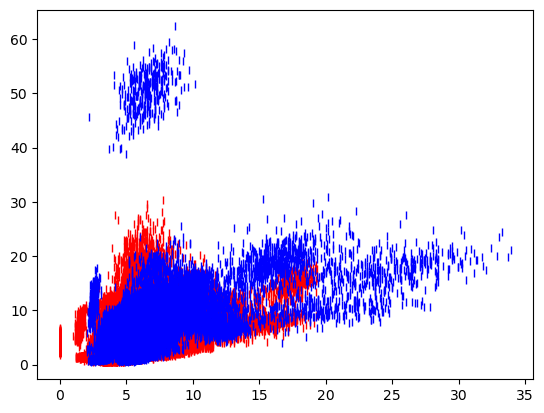

In [9]:
plt.plot(Xpois, y_pois, 'r|')
plt.plot(Xed, y_ed, 'b|')

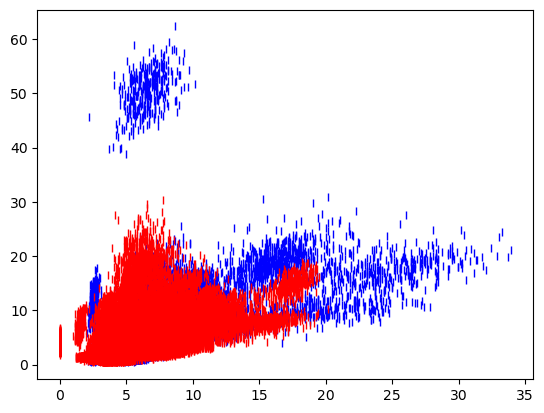

In [11]:
plt.plot(Xed, y_ed, 'b|')
plt.plot(Xpois, y_pois, 'r|')

We can see that there are some clusters, but there seems to be a lot of overlap in the bottom portion. We replotted the data as the blue was blocking some of the red behind, so this gives us a better idea of where all the datapoints are. We can see that some of the data is linearly seperable, but most of the data is not. We will see this reflected in the algorithms we chose to implement.

## KNN

We decided to do KNN as it was the first machine learning algorithm we learned and it seems like it is the simplist.

In [13]:
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train, y_train)
y_pred_test = knn_model.predict(X_test)
y_pred_train = knn_model.predict(X_train)
print("Training set score: {:.4}".format(np.mean(y_pred_train == y_train)))
print("Test set score: {:.4}".format(np.mean(y_pred_test == y_test)))

Training set score: 0.9969
Test set score: 0.9933


Surprisingly, we find that KNN performs very well with both the training set and test set. When we reduced the number of neighbors down to 1, the test set still had a score of around 0.99, and the training set had a score of 1.0. When playing with it, we noticed that the higher the neighbors, the lower the score we got. We found that 2 neighbors gave us the best score. We assume that the data on each classification have neighbors that are very close to each other that most likely, the closest one is classified the same as the one in question.

## SVM

We then used SVM with our dataset with and without PCA. This takes a long time to run.

In [15]:
# With PCA
pca_svm = PCA(n_components=10)
svm_model = SVC(kernel='linear', C=.5)
scaler_svm = StandardScaler()
pipe_svm = Pipeline(steps=[("scaler", scaler_svm), ("pca", pca_svm), ("SVM", svm_model)])
pipe_svm.fit(X_train, y_train)

y_pred_test_pca_svm = pipe_svm.predict(X_test)
y_pred_train_pca_svm = pipe_svm.predict(X_train)

accuracy_test_pca_svm = round(accuracy_score(y_test, y_pred_test_pca_svm), 4)
accuracy_train_pca_svm = round(accuracy_score(y_train, y_pred_train_pca_svm), 4)

print("SVM Using PCA:")
print(f"-Training Set: {accuracy_train_pca_svm}")
print(f"-Test Set: {accuracy_test_pca_svm}")

SVM Using PCA:
-Training Set: 0.6295
-Test Set: 0.628


In [25]:
# Without PCA
svm_model.fit(X_train, y_train)

y_pred_test_svm_no_pca = svm_model.predict(X_test)
y_pred_train_svm_no_pca = svm_model.predict(X_train)

accuracy_test_svm_no_pca = round(accuracy_score(y_test, y_pred_test_svm_no_pca), 4)
accuracy_train_svm_no_pca = round(accuracy_score(y_train, y_pred_train_svm_no_pca), 4)

print("\nSVM with no PCA:")
print(f"Training Set: {accuracy_train_svm_no_pca}")
print(f"Test Set: {accuracy_test_svm_no_pca}")


SVM with no PCA:
Training Set: 0.6272
Test Set: 0.6254


As you can see, it doesn't do too well; it does slightly better than flipping a coin. This makes sense because, when we looked at the graph earlier, we saw a big cluster where both the poisonous and edible mushrooms lay. It didn't seem like it was linearly separable in that region, so I doubt there is a hyperplane that separates the data in multidimensions. When we ran with PCA, it computed a lot faster than without it, but it did sacrifice a little on performance. The more we reduced the number of n_components, the worse the accuracy got. This makes sense as we're reducing the components, we are losing a bit more information. We found that having 10 n_components preserved the most performance while reducing computing time. We have 11 features, so the more information we kept, the better performance we got while getting better computation time. A couple times we ran it, SVM with PCA did better than without PCA.

## Logistic Regression

In [20]:
pca = PCA(n_components=10)
logreg_model = LogisticRegression(max_iter=1000)
scaler = StandardScaler()
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logreg_model)])
pipe.fit(X_train, y_train)

y_pred_test_pca = pipe.predict(X_test)
y_pred_train_pca = pipe.predict(X_train)

accuracy_test_pca = round(accuracy_score(y_test, y_pred_test_pca), 4)
accuracy_train_pca = round(accuracy_score(y_train, y_pred_train_pca), 4)

logreg_model.fit(X_train, y_train)

y_pred_test_no_pca = logreg_model.predict(X_test)
y_pred_train_no_pca = logreg_model.predict(X_train)

accuracy_test_no_pca = round(accuracy_score(y_test, y_pred_test_no_pca), 4)
accuracy_train_no_pca = round(accuracy_score(y_train, y_pred_train_no_pca), 4)

print("Using PCA:")
print(f"-Test Set: {accuracy_test_pca}")
print(f"-Training Set: {accuracy_train_pca}")

print("\nNo PCA:")
print(f"-Test Set: {accuracy_test_no_pca}")
print(f"-Training Set: {accuracy_train_no_pca}")

Using PCA:
-Test Set: 0.6106
-Training Set: 0.6167

No PCA:
-Test Set: 0.6108
-Training Set: 0.6164


PCA Components Heatmap
The PCA components heatmap visually represents how each original feature in the mushroom dataset contributes to the first ten principal components. Each row corresponds to a principal component, while each column represents an original feature. The color indicates the weight of a feature on a particular principal component. For example, if certain features consistently show high positive or negative weights across the first few principal components, it suggests these features capture much of the variance in the dataset and are key drivers in distinguishing between edible and poisonous mushrooms. 

C:\Users\ianwe\AppData\Local\Temp\ipykernel_22636\2196722844.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


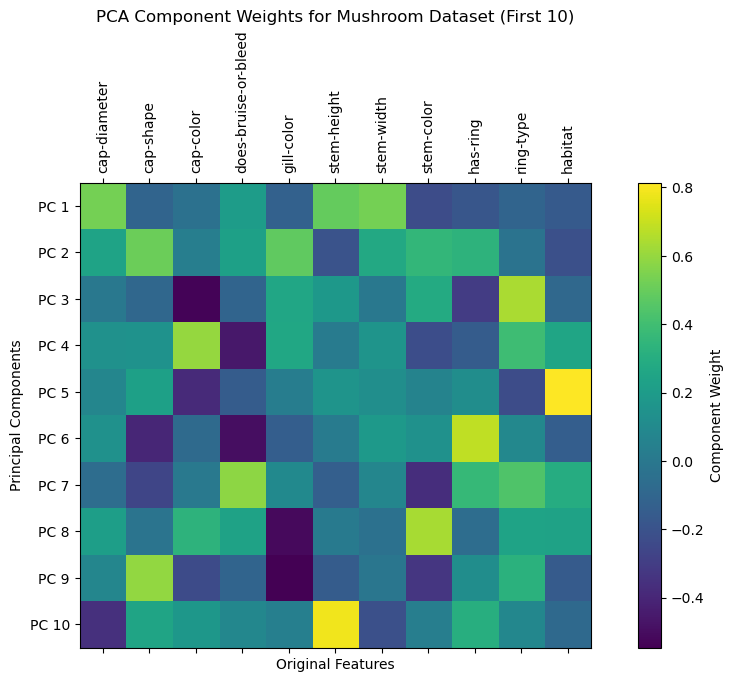

In [23]:
feature_names = shroom.columns[1:]

# Plot PCA components heatmap
plt.figure(figsize=(12, 6))
plt.matshow(pca.components_, cmap='viridis', fignum=1)
plt.yticks(range(10), [f'PC {i+1}' for i in range(10)])
plt.colorbar(label='Component Weight')
plt.xticks(range(len(feature_names)), feature_names, rotation=90, ha='center')
plt.xlabel("Original Features")
plt.ylabel("Principal Components")
plt.title("PCA Component Weights for Mushroom Dataset (First 10)")
plt.tight_layout()
plt.show()

# Conclusion

We see from these machine learning techniques that KNN does the best job at classifying mushrooms as either edible or poisonous. We're not entirely sure why this is, but we guess that these mushrooms have clusters among the different features put together. However, we're not sure why SVM wouldn't pick up on these clusters. We can see from the other graphs that there seem to be groups of mushrooms by classification in multiple graphs.